In [3]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "../00_setup.py").load_module()

# XGBoost with Mean Encoded NAICS (Grouped, 4 digit)
Same as the baseline but include the mean encoded NAICS, where NAICS mean encoded by sector

*This script takes about 5 minutes on my MacBook Air*

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle, os

In [9]:
os.chdir('..')

In [10]:
from pathlib import Path

In [11]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [12]:
from sba_gnn.sba_gnn import sg_plot 

In [16]:
from sklearn.preprocessing import TargetEncoder

## Import Processed Datasets

In [40]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet')) \
    .drop(columns='menc_grp_NAICS', errors='ignore')
sba_loans['naics4'] = sba_loans['NAICS'].str[0:4]

In [41]:
sba_loans['naics4'].head()

index
0    4511
1    7224
2    6212
5    3327
7    8111
Name: naics4, dtype: object

In [42]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

## Encode using 4-digit NAICS

In [43]:
naics_encoder = TargetEncoder(target_type='binary', random_state=3434)
naics_encoder.set_output(transform='pandas')

TargetEncoder(random_state=3434, target_type='binary')

In [44]:
train_out = naics_encoder.fit_transform(train_df[['naics4']], train_df['target']).set_axis(['menc_grp_NAICS'], axis=1)

In [46]:
test_out = naics_encoder.transform(test_df[['naics4']]).set_axis(['menc_grp_NAICS'], axis=1)
val_out = naics_encoder.transform(val_df[['naics4']]).set_axis(['menc_grp_NAICS'], axis=1)

In [47]:
train_df = pd.concat([train_df.drop(columns='menc_grp_NAICS', errors='ignore'), train_out], axis=1)
test_df = pd.concat([test_df.drop(columns='menc_grp_NAICS', errors='ignore'), test_out], axis=1)
val_df = pd.concat([val_df.drop(columns='menc_grp_NAICS', errors='ignore'), val_out], axis=1)

In [63]:
sba_loans = pd.concat([train_df, test_df, val_df]).sort_index()

#### Set the predictor features.  Inlcude the group-mean-encoded NAICS

In [48]:
predictor_features = setup.predictor_features + ['menc_grp_NAICS']
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'menc_grp_NAICS']


In [49]:
train_df[predictor_features].describe()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,menc_grp_NAICS
count,425594.000000,425594.000000,422477.000000,4.255940e+05,425050.000000,342255.000000,425594.000000,425594.000000
mean,9.758920,2.172277,0.097807,1.949280e+05,0.279906,0.814930,0.050858,0.203063
std,63.011166,15.140139,0.297053,2.994808e+05,0.448953,0.388355,0.219709,0.086274
min,0.000000,0.000000,0.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,3.600000e+04,0.000000,1.000000,0.000000,0.133380
50%,4.000000,0.000000,0.000000,9.000000e+04,0.000000,1.000000,0.000000,0.202309
75%,9.000000,2.000000,0.000000,2.157000e+05,1.000000,1.000000,0.000000,0.261550
max,9992.000000,5621.000000,1.000000,1.144632e+07,1.000000,1.000000,1.000000,0.504463


In [50]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,menc_grp_NAICS,target
NoEmp,1.000000,0.052510,-0.009243,0.093125,-0.038672,0.002058,0.006517,-0.021942,-0.027838
CreateJob,0.052510,1.000000,-0.046967,0.101755,0.028831,0.009019,0.036918,0.004533,-0.009540
LowDoc,-0.009243,-0.046967,1.000000,-0.133731,0.154037,-0.119292,0.039258,-0.065580,-0.076836
DisbursementGross,0.093125,0.101755,-0.133731,1.000000,-0.067410,-0.006023,0.082087,-0.181950,-0.122857
new_business,-0.038672,0.028831,0.154037,-0.067410,1.000000,-0.046626,0.136142,0.025409,0.014277
urban_flag,0.002058,0.009019,-0.119292,-0.006023,-0.046626,1.000000,-0.004093,0.047989,0.054391
franchise_flag,0.006517,0.036918,0.039258,0.082087,0.136142,-0.004093,1.000000,0.038470,-0.011047
menc_grp_NAICS,-0.021942,0.004533,-0.065580,-0.181950,0.025409,0.047989,0.038470,1.000000,0.210400
target,-0.027838,-0.009540,-0.076836,-0.122857,0.014277,0.054391,-0.011047,0.210400,1.000000


In [51]:
with open(Path(setup.temp_path).joinpath('X08_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [52]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [53]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [54]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)

In [55]:
xgb_model = xgb_model.set_params(**xgb_params)

In [56]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.49882	validation_1-logloss:0.50163
[1]	validation_0-logloss:0.49175	validation_1-logloss:0.49447
[2]	validation_0-logloss:0.48577	validation_1-logloss:0.48846
[3]	validation_0-logloss:0.48068	validation_1-logloss:0.48334
[4]	validation_0-logloss:0.47619	validation_1-logloss:0.47886
[5]	validation_0-logloss:0.47243	validation_1-logloss:0.47506
[6]	validation_0-logloss:0.46930	validation_1-logloss:0.47194
[7]	validation_0-logloss:0.46650	validation_1-logloss:0.46917
[8]	validation_0-logloss:0.46417	validation_1-logloss:0.46684
[9]	validation_0-logloss:0.46217	validation_1-logloss:0.46485
[10]	validation_0-logloss:0.46035	validation_1-logloss:0.46307
[11]	validation_0-logloss:0.45877	validation_1-logloss:0.46150
[12]	validation_0-logloss:0.45744	validation_1-logloss:0.46022
[13]	validation_0-logloss:0.45633	validation_1-logloss:0.45910
[14]	validation_0-logloss:0.45528	validation_1-logloss:0.45809
[15]	validation_0-logloss:0.45442	validation_1-logloss:0.45723
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [57]:
train_df['target'].value_counts()

target
0    339167
1     86427
Name: count, dtype: int64

##### Save the model

In [58]:
xgb_model.save_model(Path(setup.temp_path).joinpath('X08_MODEL_xgboost.json'))

In [59]:
with open(Path(setup.temp_path).joinpath('X08_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [64]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [65]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.184469,0.113718,0.01625,0.614106,0.169696
1,0.280467,0.106497,0.01625,0.652266,0.290091


## Decision Threshold
Max f1, on training data

In [66]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [67]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [68]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('X08_REPORT_thresh_tune.csv'), index=False)

In [69]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.22


,thresh,f1
11,0.22,0.449551
12,0.24,0.448876


##### Apply decision threshold
All datasets

In [70]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [71]:
pred_df['predict_bin'].value_counts()

predict_bin
0    372973
1    315108
Name: count, dtype: int64

In [72]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('X08_DATA_combined_predictions.parquet'))

## Metrics

In [73]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('X08_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.636640,0.443651,0.320098,0.722541,0.377936,0.728046,NaN
1,train,0.635373,0.449551,0.324148,0.733208,0.382632,0.730642,NaN
2,val,0.634817,0.450478,0.326074,0.728361,0.383791,0.729038,NaN
0,test,0.634599,0.447527,0.323361,0.726485,0.383938,0.728712,0.0
1,test,0.642958,0.431011,0.309521,0.709495,0.356752,0.725205,1.0


## Lift
Test data

In [74]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

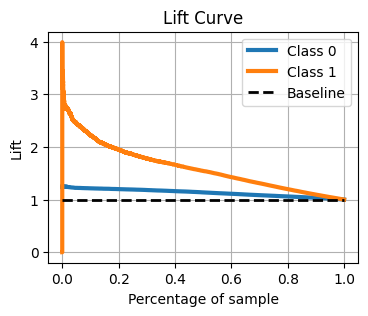

In [75]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('X08_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [76]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [77]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('X08_REPORT_importance_gain.csv'), index=True)

In [78]:
feat_impgain.head()

,importance
urban_flag,556.983887
LowDoc,98.807907
DisbursementGross,67.545746
menc_grp_NAICS,44.658096
CreateJob,20.788797


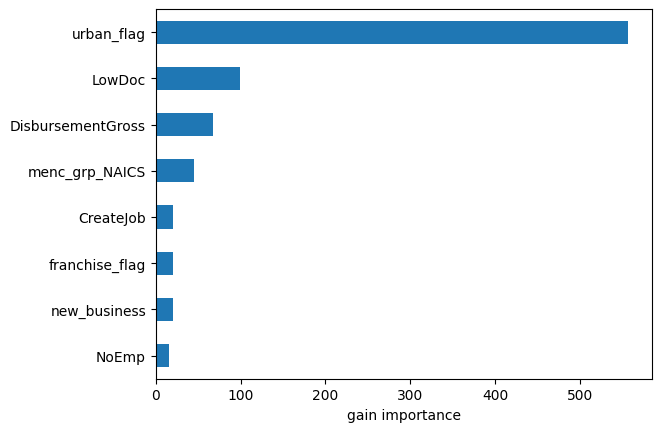

In [79]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('X08_PLOT_importance_gain.png'))

##### Permutation Importance

In [80]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [81]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [82]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.071535,0.071535
7,menc_grp_NAICS,0.068447,0.068447
5,urban_flag,0.040807,0.040807
1,CreateJob,0.021514,0.021514
2,LowDoc,0.014552,0.014552


In [83]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('X08_DATA_importance_perturb.csv'),
            index=False)

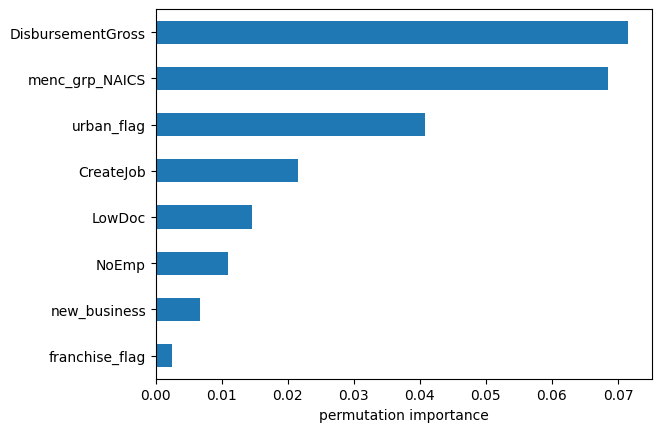

In [84]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('X08_PLOT_importance_perturb.png'))

## PDP Plot - NAICS mean encoded

In [85]:
results = partial_dependence(xgb_model, train_df[predictor_features], ['menc_grp_NAICS'])
pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})

In [86]:
plt.close()

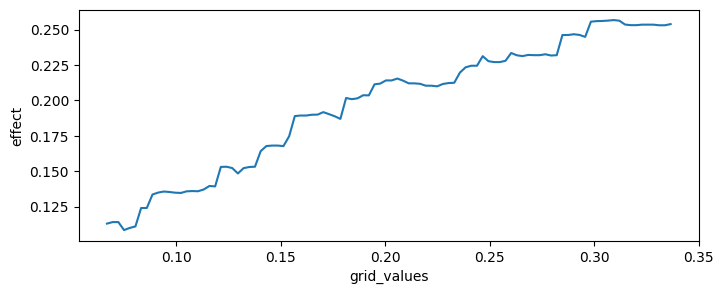

In [87]:
fig, ax = plt.subplots(figsize = (8, 3))
pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax)
ax.set_ylabel('effect')
fig.savefig(Path(setup.temp_path).joinpath('X08_PLOT_pdp_naics_meanenc.png'),
               bbox_inches='tight')